In [ ]:
!pip install alpha_vantage pandas numpy matplotlib yfinance newsapi-python textblob quandl tweepy fredapi xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 5.3 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from textblob import TextBlob
from newsapi import NewsApiClient
import requests
import tweepy
from fredapi import Fred
import json

# Initialize API clients
newsapi = NewsApiClient(api_key='b7e99c51eaf3492e81ef8d2f206cbb86')

# FIX: Ensure you have a valid FRED API key
FRED_API_KEY = "50113643558d6e3a373925ec8d3f9b57"
fred = Fred(api_key=FRED_API_KEY)

# Initialize Tweepy API for Twitter sentiment analysis
twitter_auth = tweepy.OAuthHandler('WOR1qlYILo9F2n5EKVJ1KTmVV', 'pHJUMNkryr0bIRAPPxcof0MM7YVaVuF93bTOIBNJbibZKxW9uw')
twitter_auth.set_access_token('1011195364496560128-HZLi5t3gSMdeg5osTtXG5YuvNhOXzx', 'gmGKlXmZUdQKC1olklaaRHaAyg5jzfpcOOJr7LoJ83fSZ')
twitter_api = tweepy.API(twitter_auth, wait_on_rate_limit=True)

# Alpha Vantage API Key (For corporate events)
ALPHA_VANTAGE_API_KEY = "H563VHZ8Z20EAU8U"

# Function to flatten DataFrame columns
def flatten_columns(df):
    """Flatten MultiIndex columns and rename 'Date_' to 'Date'."""
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]

    if 'Date_' in df.columns:
        df.rename(columns={'Date_': 'Date'}, inplace=True)

# Fetch Market Indices (S&P 500, DJIA, NASDAQ)
def fetch_index_data(symbols, start_date, end_date):
    """Fetches multiple market index data from Yahoo Finance."""
    index_data = yf.download(symbols, start=start_date, end=end_date, group_by='ticker')
    index_data = index_data.stack(level=0, future_stack=True).rename_axis(['Date', 'Ticker']).reset_index()  # FIXED FutureWarning
    flatten_columns(index_data)
    return index_data[['Date', 'Ticker', 'Close']]

# Fetch Stock Data
def fetch_stock_data(symbol, start_date, end_date):
    """Fetches stock data from Yahoo Finance and computes indicators."""
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    flatten_columns(stock_data)

    if 'Close' in stock_data.columns:
        stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
        stock_data['EMA_20'] = stock_data['Close'].ewm(span=20, adjust=False).mean()
        stock_data['MACD'] = stock_data['Close'].ewm(span=12, adjust=False).mean() - stock_data['Close'].ewm(span=26, adjust=False).mean()
        stock_data['OBV'] = (np.sign(stock_data['Close'].diff()) * stock_data['Volume']).cumsum()
        stock_data['VWAP'] = (stock_data['Close'] * stock_data['Volume']).cumsum() / stock_data['Volume'].cumsum()

    return stock_data

# Fetch Economic Indicators (Including Unemployment Rate)
# Fetch Economic Indicators (Including Unemployment Rate)
def fetch_fred_data(series_ids, start_date, end_date):
    """Fetch multiple economic data series from FRED and rename columns uniquely."""
    dfs = []
    for series_id in series_ids:
        try:
            data = fred.get_series(series_id, start_date, end_date)
            df = pd.DataFrame({'Date': data.index, f"{series_id}_Value": data.values})  # Rename column uniquely
            df['Date'] = pd.to_datetime(df['Date'])
            dfs.append(df)
        except Exception as e:
            print(f"⚠️ Failed to fetch {series_id} from FRED: {e}")

    if dfs:
        result_df = pd.concat(dfs, axis=1)
        result_df = result_df.loc[:, ~result_df.columns.duplicated()]  # Remove duplicate columns
        return result_df
    else:
        return pd.DataFrame()


# Merge Data
# Merge Data with Duplicate Handling
def merge_data(stock_data, index_data, economic_data):
    """Merges stock data with index & economic data while preventing duplicate column names."""
    if economic_data.empty:
        print("⚠️ Economic Data is missing, skipping merge.")
        return stock_data  # Proceed with available data

    for df in [stock_data, index_data, economic_data]:
        df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date column is in datetime format

    # Merge with suffixes to avoid duplicate columns
    merged_data = stock_data.merge(index_data, on=['Date'], how='left', suffixes=('', '_Index'))
    merged_data = merged_data.merge(economic_data, on=['Date'], how='left', suffixes=('', '_Econ'))

    # Drop any remaining duplicate columns
    merged_data = merged_data.loc[:, ~merged_data.columns.duplicated()]

    return merged_data


# Process and Save Data
def process_tickers(tickers, start_date, end_date, output_dir):
    """Processes each ticker: fetches data, computes indicators, merges, and saves."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    index_data = fetch_index_data(['^GSPC', '^DJI', '^IXIC'], start_date, end_date)
    economic_data = fetch_fred_data(['DGS10', 'GDP', 'CPIAUCSL', 'UNRATE'], start_date, end_date)

    for ticker in tickers:
        print(f"🔄 Processing {ticker}")
        stock_data = fetch_stock_data(ticker, start_date, end_date)
        flatten_columns(stock_data)

        if not stock_data.empty:
            merged_data = merge_data(stock_data, index_data, economic_data)
            if not merged_data.empty:
                file_path = os.path.join(output_dir, f'{ticker}_financial_data.csv')
                merged_data.to_csv(file_path, index=False)
                print(f"✅ Saved data for {ticker} to {file_path}")
            else:
                print(f"⚠️ Skipping {ticker} due to incomplete data.")

if __name__ == "__main__":
    tickers = ['AAPL', 'MSFT', 'GOOGL']
    start_date = '2022-01-01'
    end_date = '2023-01-01'
    output_dir = './output'
    process_tickers(tickers, start_date, end_date, output_dir)


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

🔄 Processing AAPL
✅ Saved data for AAPL to ./output/AAPL_financial_data.csv
🔄 Processing MSFT
✅ Saved data for MSFT to ./output/MSFT_financial_data.csv
🔄 Processing GOOGL
✅ Saved data for GOOGL to ./output/GOOGL_financial_data.csv


In [ ]:
import pandas as pd
import os

def load_and_combine_data(tickers, output_dir):
    """Loads data for each ticker and combines into a single DataFrame using advanced merging strategies."""
    data_frames = []
    for ticker in tickers:
        file_path = os.path.join(output_dir, f'{ticker}_financial_data.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['Ticker'] = ticker  # Add ticker identifier to the data
            df['Date'] = pd.to_datetime(df['Date'])
            data_frames.append(df)
        else:
            print(f"File for {ticker} not found in {output_dir}")

    if data_frames:
        combined_df = pd.concat(data_frames, ignore_index=True)
        return combined_df
    else:
        return pd.DataFrame()  # Return empty DataFrame if no data was loaded

def clean_data(df):
    """Cleans the combined dataframe by handling missing values and standardizing formats."""
    df.sort_values(by=['Date', 'Ticker'], inplace=True)
    # More sophisticated fill methods might be added here
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    return df

def check_data_quality(df):
    """Checks for common data quality issues."""
    if df.isnull().any().any():
        print("Warning: There are still missing values in the data.")
    if df.duplicated().any():
        print("Warning: There are duplicated entries in the data.")

# Set the directory where your files are saved
output_dir = './output'
tickers = ['AAPL', 'MSFT', 'GOOGL']

# Load and combine data from the specified tickers
combined_data = load_and_combine_data(tickers, output_dir)

# Clean the combined data
cleaned_data = clean_data(combined_data)

# Data quality check
check_data_quality(cleaned_data)

# Optionally, save the cleaned data to a new file
cleaned_data.to_csv(os.path.join(output_dir, 'combined_cleaned_data.csv'), index=False)

print("Data loading, combining, and cleaning complete. Cleaned data saved to 'combined_cleaned_data.csv'.")


Data loading, combining, and cleaning complete. Cleaned data saved to 'combined_cleaned_data.csv'.


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming the combined and cleaned data file is saved as 'combined_cleaned_data.csv' in the 'output' directory
file_path = './output/combined_cleaned_data.csv'

# Load the cleaned data
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature Engineering
# Lagged Variables for stock prices
lags = [1, 3, 7]  # Example lags for 1 day, 3 days, and 7 days
for lag in lags:
    for column in ['Close_AAPL', 'Close_MSFT', 'Close_GOOGL']:
        data[f'{column}_lag{lag}'] = data[column].shift(lag)

# Rolling Statistics for capturing trends and volatility
rolling_windows = [7, 14, 30]  # 1 week, 2 weeks, and 1 month windows
for window in rolling_windows:
    for column in ['Close_AAPL', 'Close_MSFT', 'Close_GOOGL']:
        data[f'{column}_rolling_mean_{window}'] = data[column].rolling(window=window).mean()
        data[f'{column}_rolling_std_{window}'] = data[column].rolling(window=window).std()

# Interaction Terms between stock prices and economic indicators
economic_indicators = ['DGS10_Value', 'GDP_Value', 'CPIAUCSL_Value']  # Example economic indicators
for stock in ['Close_AAPL', 'Close_MSFT', 'Close_GOOGL']:
    for econ in economic_indicators:
        data[f'{stock}_x_{econ}'] = data[stock] * data[econ]

# Data Transformation: Normalize or Scale Data for Neural Network readiness
scaler = MinMaxScaler()
numerical_cols = [col for col in data.columns if data[col].dtype in ['float64', 'int64']]
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Save the engineered data to a new CSV file for further analysis or modeling
data.to_csv('./output/data_with_features.csv')

print("Feature engineering complete. Engineered data saved to 'data_with_features.csv'.")


Feature engineering complete. Engineered data saved to 'data_with_features.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load the feature-engineered dataset
file_path = './output/data_with_features.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Target Variable: Predict next day's Apple Closing Price
data['Close_AAPL_future'] = data['Close_AAPL'].shift(-1)  # Shift target column to predict next day's price

# Drop rows with NaN values due to shifting or rolling operations
data.dropna(inplace=True)

# Define Features and Target
features = data.drop(columns=['Close_AAPL_future', 'Ticker'])  # Remove target & categorical columns
target = data['Close_AAPL_future']

# Split Data into Train (70%), Validation (15%), Test (15%)
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - (train_size + val_size)

X_train, X_val, X_test = np.split(features, [train_size, train_size + val_size])
y_train, y_val, y_test = np.split(target, [train_size, train_size + val_size])

# Train a Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions on Validation and Test Set
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Model Evaluation
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

val_rmse = np.sqrt(val_mse)
test_rmse = np.sqrt(test_mse)

val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print Results
print(f"Model Performance on Validation Set:")
print(f"MAE: {val_mae:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
print("\nModel Performance on Test Set:")
print(f"MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

# Save the model (optional)
import joblib
joblib.dump(model, './output/random_forest_stock_model.pkl')

print("Model training complete. Saved trained model to 'random_forest_stock_model.pkl'.")


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Model Performance on Validation Set:
MAE: 0.0217, MSE: 0.0008, RMSE: 0.0291, R²: 0.9179

Model Performance on Test Set:
MAE: 0.0225, MSE: 0.0012, RMSE: 0.0347, R²: 0.9341
Model training complete. Saved trained model to 'random_forest_stock_model.pkl'.


In [ ]:
# Import necessary libraries
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,  # Tree depth
    subsample=0.8,  # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=42
)

# Train the model on training data
xgb_model.fit(X_train, y_train)

# Make predictions on validation & test sets
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost Model
val_mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)

val_mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
test_mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)

val_rmse_xgb = np.sqrt(val_mse_xgb)
test_rmse_xgb = np.sqrt(test_mse_xgb)

val_r2_xgb = r2_score(y_val, y_val_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)

# Print Results
print(f"XGBoost Model Performance on Validation Set:")
print(f"MAE: {val_mae_xgb:.4f}, MSE: {val_mse_xgb:.4f}, RMSE: {val_rmse_xgb:.4f}, R²: {val_r2_xgb:.4f}")

print("\nXGBoost Model Performance on Test Set:")
print(f"MAE: {test_mae_xgb:.4f}, MSE: {test_mse_xgb:.4f}, RMSE: {test_rmse_xgb:.4f}, R²: {test_r2_xgb:.4f}")

# Save the XGBoost model
import joblib
joblib.dump(xgb_model, './output/xgboost_stock_model.pkl')

print("XGBoost model training complete. Saved trained model to 'xgboost_stock_model.pkl'.")


XGBoost Model Performance on Validation Set:
MAE: 0.0344, MSE: 0.0023, RMSE: 0.0475, R²: 0.7802

XGBoost Model Performance on Test Set:
MAE: 0.0453, MSE: 0.0034, RMSE: 0.0586, R²: 0.8115
XGBoost model training complete. Saved trained model to 'xgboost_stock_model.pkl'.


<ipython-input-15-d24418d23a2e>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importance_df['Importance'][:10], y=rf_importance_df['Feature'][:10], palette="Blues_r")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


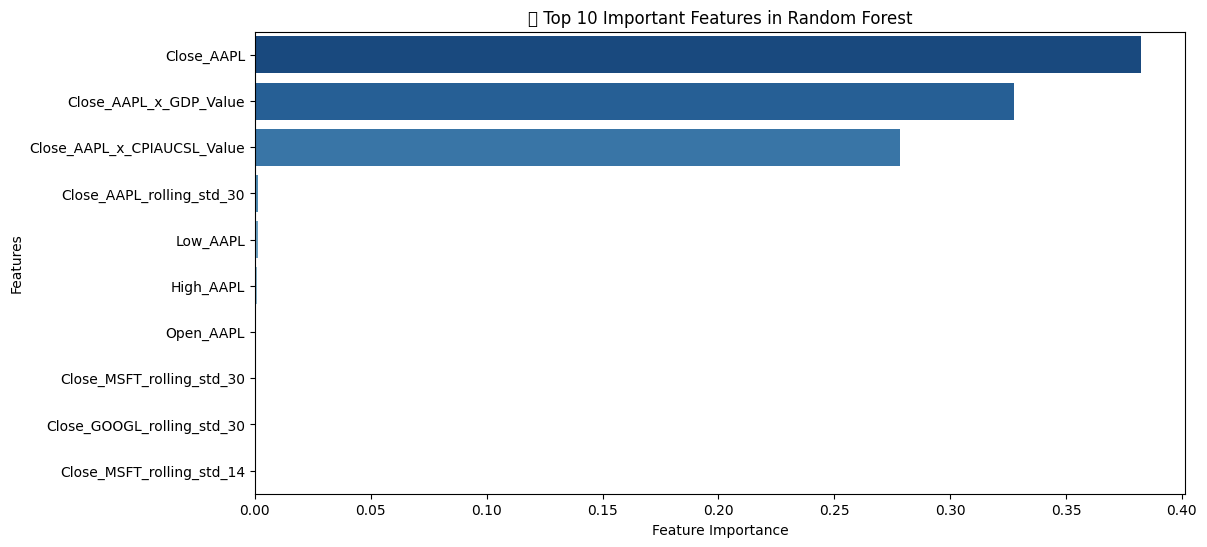

<ipython-input-15-d24418d23a2e>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importance_df['Importance'][:10], y=xgb_importance_df['Feature'][:10], palette="Oranges_r")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


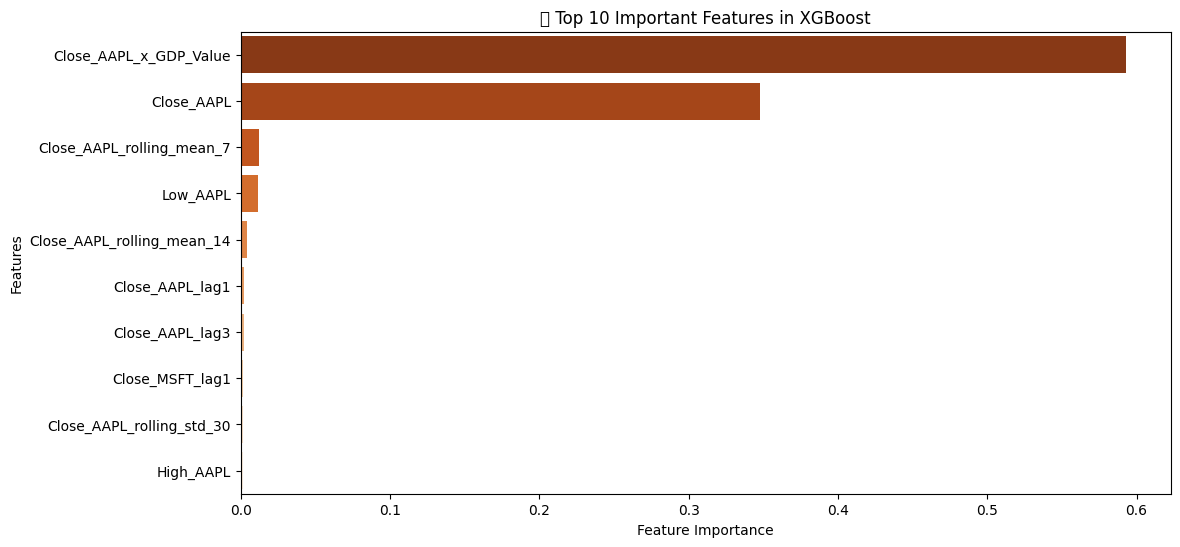

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get Feature Importances from Random Forest
rf_feature_importance = model.feature_importances_
rf_features = X_train.columns

# Convert to DataFrame
rf_importance_df = pd.DataFrame({'Feature': rf_features, 'Importance': rf_feature_importance})
rf_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot Feature Importances for Random Forest
plt.figure(figsize=(12, 6))
sns.barplot(x=rf_importance_df['Importance'][:10], y=rf_importance_df['Feature'][:10], palette="Blues_r")
plt.title("🔹 Top 10 Important Features in Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

# Get Feature Importances from XGBoost
xgb_feature_importance = xgb_model.feature_importances_
xgb_features = X_train.columns

# Convert to DataFrame
xgb_importance_df = pd.DataFrame({'Feature': xgb_features, 'Importance': xgb_feature_importance})
xgb_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot Feature Importances for XGBoost
plt.figure(figsize=(12, 6))
sns.barplot(x=xgb_importance_df['Importance'][:10], y=xgb_importance_df['Feature'][:10], palette="Oranges_r")
plt.title("🔹 Top 10 Important Features in XGBoost")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()
